In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [50]:
# constants

# dummy data for the example.
# replace this with the real report!
CHROMATIC_USAGE_CSV = 'chromatic-usage-report.dummy.csv'

# optional: filter analysis to a single repository (set to `None` to analyze all repositories)
# repository names should match those in the "Repository slug" column (normalized to lowercase)
# this will *skip* running any account level analytics, like your billing overages or repo-level usage!
FILTER_TO_REPOSITORY = None

# details from your billing contract
# be aware that this will become completely inaccurate if you changed your contract during the period
# that your data covers. if you need to handle fancy situations like that... that's up to you!
BILLING_PERIOD_START_DAY = 1
CONTRACT_SNAPSHOT_LIMIT = 3_000_000
CONTRACT_OVERAGE_COST = 0.006

In [51]:
# utils

def title(text):
    print("=" * 50)
    print(text)
    print("=" * 50)
    print()


# Chromatic billing periods are monthly, but don't necessarily start on the first of the month.
# here are some utliltiies to help with that.

def calculate_billing_period(date):
    """
    calculate which billing period a date belongs to.

    billing periods are monthly, but don't necessarily start on the first of the month.
    this function calculates which billing period a date belongs to.
    
    
    Parameters:
    - date: pandas datetime object
    - start_day: int, day of month when billing period starts (default: 1)
    
    Returns:
    - str: billing period in 'YYYY-MM' format
    
    Examples:
    - start_day=1: standard calendar months (1st-31st/30th/28th)
    - start_day=17: custom period (17th-16th of each month)
    """
    if date.day >= BILLING_PERIOD_START_DAY:
        # billing period is current month
        billing_month = date.replace(day=1)
    else:
        # billing period is previous month
        if date.month == 1:
            billing_month = date.replace(year=date.year-1, month=12, day=1)
        else:
            billing_month = date.replace(month=date.month-1, day=1)
    
    return billing_month.strftime('%Y-%m')


In [52]:

# load the CSV data

df = pd.read_csv(CHROMATIC_USAGE_CSV, parse_dates=['Date'])

# fill NaN values with 0 for numeric columns
snapshot_cols = ['Chrome snapshots', 'Firefox snapshots', 
                'Internet Explorer snapshots', 'Safari snapshots', 'Edge snapshots',
                'Accessibility snapshots']
snapshot_and_turbo_cols = ['TurboSnaps'] + snapshot_cols
df[snapshot_and_turbo_cols] = df[snapshot_and_turbo_cols].fillna(0)

# normalize the repository names
df["Repository slug"] = df["Repository slug"].str.lower()

if FILTER_TO_REPOSITORY is not None:
    df = df[df["Repository slug"] == FILTER_TO_REPOSITORY]

# add a column for the billing period
df["Billing Period"] = df["Date"].apply(lambda x: calculate_billing_period(x))

# add some columns for total billed, captured, and potential snapshots.
# we'll need these later to calculate billing and skip rates.
SNAPSHOTS_PER_TURBO_SNAP = 0.2
df['Total Captured Snapshots'] = df[snapshot_cols].sum(axis=1)
df["Total Billed Snapshots"] = df['Total Captured Snapshots'] + (df["TurboSnaps"] * SNAPSHOTS_PER_TURBO_SNAP)
df['Total Potential Snapshots'] = df['TurboSnaps'] + df['Total Captured Snapshots']

print(f"\ndata shape: {df.shape}")
print(f"\ncolumns: {list(df.columns)}")
print(f"\nfirst few rows:")
df.head()


data shape: (14465, 18)

columns: ['Date', 'App ID', 'Build ID', 'Repository slug', 'Branch name', 'Build number', 'TurboSnaps', 'Chrome snapshots', 'Firefox snapshots', 'Internet Explorer snapshots', 'Safari snapshots', 'Edge snapshots', 'Accessibility snapshots', 'TurboSnap Bail Reason', 'Billing Period', 'Total Captured Snapshots', 'Total Billed Snapshots', 'Total Potential Snapshots']

first few rows:


,Date,App ID,Build ID,Repository slug,Branch name,Build number,TurboSnaps,Chrome snapshots,Firefox snapshots,Internet Explorer snapshots,Safari snapshots,Edge snapshots,Accessibility snapshots,TurboSnap Bail Reason,Billing Period,Total Captured Snapshots,Total Billed Snapshots,Total Potential Snapshots
0,2024-11-11 08:37:23,adc30543fe5a6e743849e63f,228f8ed4d7cb51f2fdbffc5c,averroes/mobile-sdk,master,43409,355,237,0.0,0.0,0.0,0.0,0.0,NaN,2024-11,237.0,308.0,592.0
1,2024-11-11 09:29:08,adc30543fe5a6e743849e63f,fe9b8d8eb743ac8a41445823,averroes/mobile-sdk,update/database-cleanup,43393,372,248,0.0,0.0,0.0,0.0,0.0,NaN,2024-11,248.0,322.4,620.0
2,2024-11-11 09:46:12,adc30543fe5a6e743849e63f,3b49c9fd454b2004fac10475,averroes/mobile-sdk,update/auth-optimization,43399,255,171,0.0,0.0,0.0,0.0,0.0,NaN,2024-11,171.0,222.0,426.0
3,2024-11-11 09:53:48,adc30543fe5a6e743849e63f,cc94ff8c1d25c90426117597,averroes/mobile-sdk,feature/tests-798,43412,312,209,0.0,0.0,0.0,0.0,0.0,NaN,2024-11,209.0,271.4,521.0
4,2024-11-11 10:12:18,a043bae1603803a839c0cb52,098d2f129a31e399698e3b36,averroes/web-app,fix/deps-optimization,60038,0,1774,0.0,0.0,0.0,0.0,0.0,changedDependencies,2024-11,1774.0,1774.0,1774.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14465 entries, 0 to 14464
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         14465 non-null  datetime64[ns]
 1   App ID                       14465 non-null  object        
 2   Build ID                     14465 non-null  object        
 3   Repository slug              14465 non-null  object        
 4   Branch name                  14465 non-null  object        
 5   Build number                 14465 non-null  int64         
 6   TurboSnaps                   14465 non-null  int64         
 7   Chrome snapshots             14465 non-null  int64         
 8   Firefox snapshots            14465 non-null  float64       
 9   Internet Explorer snapshots  14465 non-null  float64       
 10  Safari snapshots             14465 non-null  float64       
 11  Edge snapshots               14465 non-nu

In [54]:
# calculate total snapshots by billing period

title("SNAPSHOT USAGE BY BILLING PERIOD")

billing_usage_cols = snapshot_and_turbo_cols + ["Total Billed Snapshots", "Total Captured Snapshots", "Total Potential Snapshots"]

df_billing_period = df.groupby('Billing Period')[billing_usage_cols].sum()
df_billing_period = df_billing_period.sort_index()

print("billing period snapshot usage summary:")
print(df_billing_period["Total Billed Snapshots"])

SNAPSHOT USAGE BY BILLING PERIOD

billing period snapshot usage summary:
Billing Period
2024-11    293697.6
2024-12    595622.4
2025-01    514739.4
2025-02    488746.4
2025-03    510425.2
2025-04    477214.0
2025-05    507191.0
2025-06    444798.6
2025-07    591339.8
2025-08    456799.2
2025-09    427584.4
2025-10    538487.2
2025-11    140162.2
Name: Total Billed Snapshots, dtype: float64


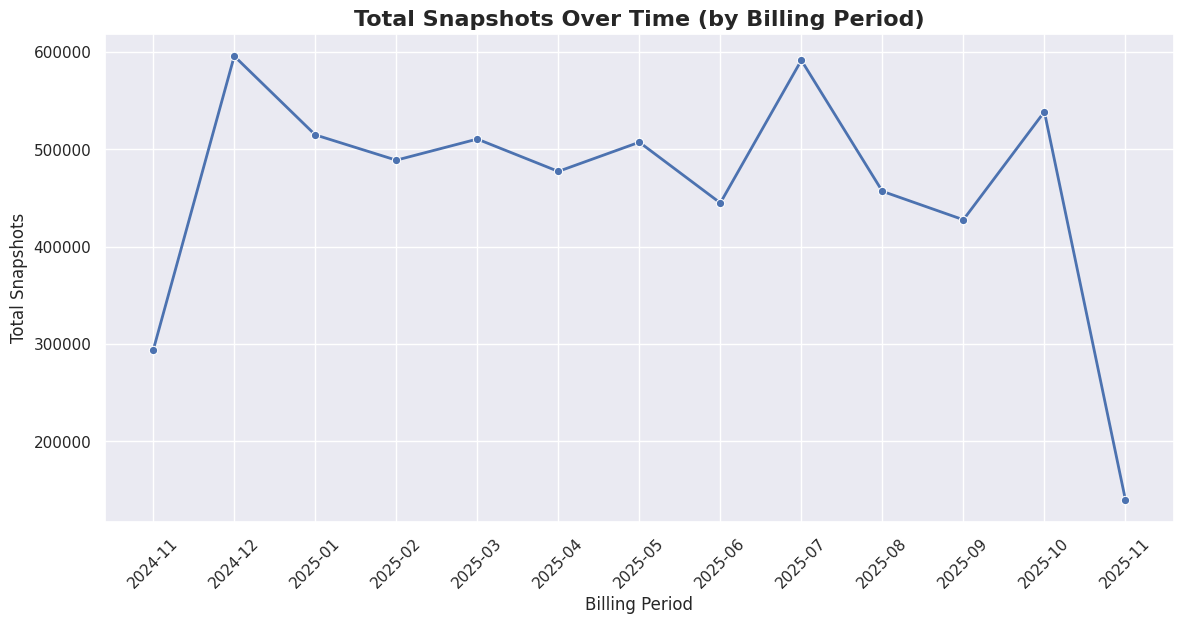

In [55]:
# graph total snapshots by billing period

fig = plt.figure(figsize=(12, 6))
sns.lineplot(data=df_billing_period, x="Billing Period", y="Total Billed Snapshots", marker='o', linewidth=2, markersize=6)
plt.title('Total Snapshots Over Time (by Billing Period)', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.xlabel('Billing Period')
plt.ylabel('Total Snapshots')
plt.xticks(rotation=45)

plt.show()

In [56]:
if FILTER_TO_REPOSITORY is None:
    # break out usage by repository

    title("SNAPSHOT USAGE BY REPOSITORY")

    # create a pivot table by repository name
    monthly_repo_snapshots = df.pivot_table(
        index='Billing Period', 
        columns='Repository slug', 
        values='Total Billed Snapshots', 
        aggfunc='sum',
        fill_value=0
    )

    print("billing period snapshots by repository (normalized):")
    display(monthly_repo_snapshots.T.style.format('{:,.0f}').background_gradient(cmap='Reds', axis=None))

SNAPSHOT USAGE BY REPOSITORY

billing period snapshots by repository (normalized):


Billing Period,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10,2025-11
Repository slug,,,,,,,,,,,,,
averroes/design-system,"27,404","49,054","59,983","50,887","56,844","47,779","50,076","46,199","53,344","49,055","56,413","54,863","15,242"
averroes/mobile-sdk,"74,742","137,007","106,706","108,095","142,321","124,820","126,321","120,143","106,069","94,717","100,555","117,640","26,279"
averroes/web-app,"191,552","409,561","348,050","329,764","311,260","304,615","330,794","278,456","431,926","313,027","270,616","365,984","98,642"


<Figure size 1200x600 with 0 Axes>

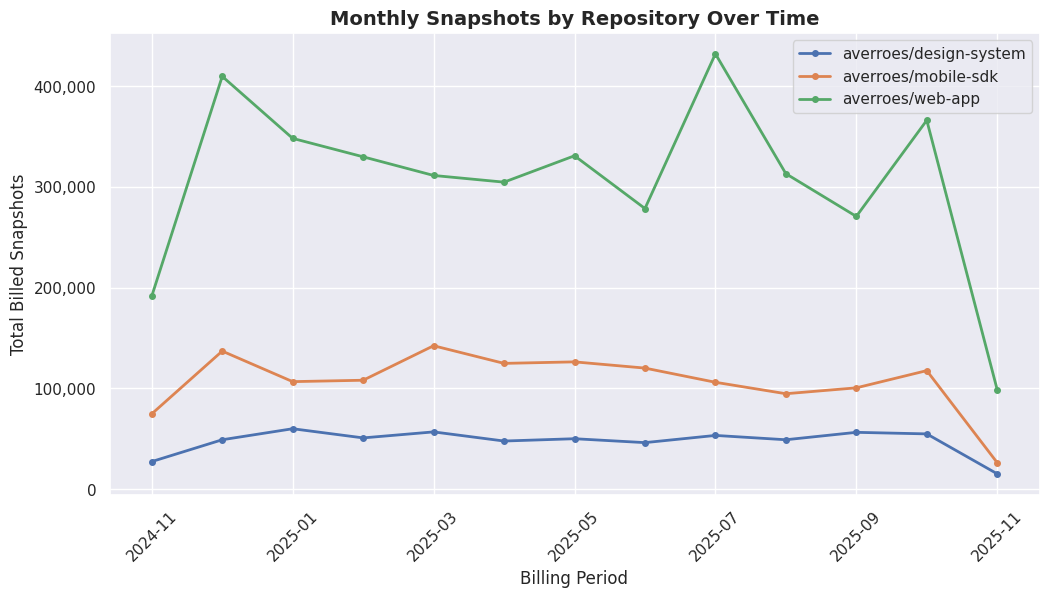

In [57]:
if FILTER_TO_REPOSITORY is None:
# graph usage by repository over time

    plt.figure(figsize=(12, 6))
    monthly_repo_snapshots.plot(kind="line", marker='o', linewidth=2, markersize=4, figsize=(12, 6))

    plt.title('Monthly Snapshots by Repository Over Time', fontsize=14, fontweight='bold')
    plt.legend()

    plt.xlabel('Billing Period')
    plt.xticks(rotation=45)

    plt.ylabel('Total Billed Snapshots')
    plt.gca().yaxis.set_major_formatter('{x:,.0f}')

    plt.show()

In [58]:
if FILTER_TO_REPOSITORY is None:
    # calculate overage for each billing period

    title("OVERAGE CALCULATION AND VISUALIZATION")

    # overage = (total snapshots - contract limit) * overage rate, but only when over your contract limit
    df_billing_period['Snapshots Over Limit'] = df_billing_period['Total Billed Snapshots'] - CONTRACT_SNAPSHOT_LIMIT
    df_billing_period['Snapshots Over Limit'] = df_billing_period['Snapshots Over Limit'].clip(lower=0)
    df_billing_period['Total Overage Cost'] = df_billing_period['Snapshots Over Limit'] * CONTRACT_OVERAGE_COST

    display(df_billing_period[['Total Billed Snapshots', 'Snapshots Over Limit', 'Total Overage Cost']].style
            .format({
                'Total Snapshots': '{:,.0f}',
                'Snapshots Over Limit': '{:,.0f}',
                'Total Overage Cost': '${:,.2f}'
            })
            .set_caption("billing period overage summary"))

    print(f"total cumulative overage cost: ${df_billing_period['Total Overage Cost'].sum():.2f}")

OVERAGE CALCULATION AND VISUALIZATION



,Total Billed Snapshots,Snapshots Over Limit,Total Overage Cost
Billing Period,,,
2024-11,293697.600000,0,$0.00
2024-12,595622.400000,0,$0.00
2025-01,514739.400000,0,$0.00
2025-02,488746.400000,0,$0.00
2025-03,510425.200000,0,$0.00
2025-04,477214.000000,0,$0.00
2025-05,507191.000000,0,$0.00
2025-06,444798.600000,0,$0.00
2025-07,591339.800000,0,$0.00


total cumulative overage cost: $0.00


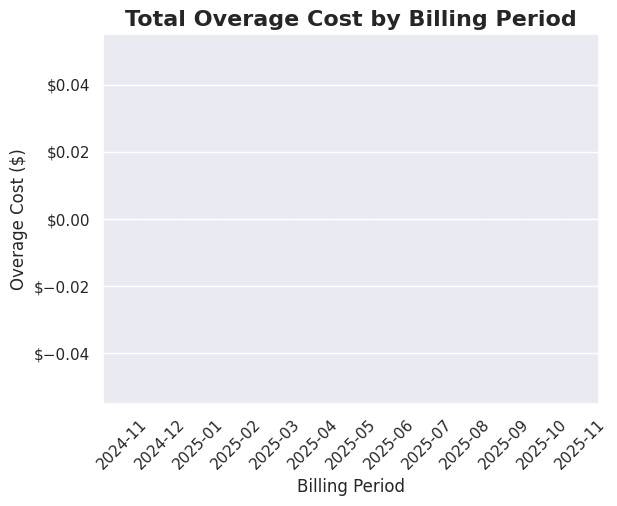

In [59]:
if FILTER_TO_REPOSITORY is None:
    # graph overages by billing period

    sns.barplot(data=df_billing_period, x='Billing Period', y='Total Overage Cost', color='red')

    plt.title('Total Overage Cost by Billing Period', fontsize=16, fontweight='bold')

    plt.xlabel('Billing Period')
    plt.xticks(rotation=45)

    plt.ylabel('Overage Cost ($)')
    plt.gca().yaxis.set_major_formatter('${x:.2f}')

    plt.show()


In [60]:
# calculate the TurboSnap skip rate

title("TURBOSNAP SKIP RATE ANALYSIS")

# skip rate = TurboSnaps / (TurboSnaps + regular snapshots)
df_billing_period['Skip Rate'] = (df_billing_period['TurboSnaps'] / df_billing_period['Total Potential Snapshots']) * 100

# calculate skip rate if we exclude builds with bail reasons.
# (this can be helpful to determine _why_ your skip rate is low:
# are your builds changing --externals a ton? is your `package.lock` changing a lot? etc.)
df_no_bail = df[df['TurboSnap Bail Reason'].isna()].copy()
df_billing_period_no_bail = df_no_bail.groupby('Billing Period')[billing_usage_cols].sum()
df_billing_period_no_bail = df_billing_period_no_bail.sort_index()
df_billing_period_no_bail['Skip Rate'] = (df_billing_period_no_bail['TurboSnaps'] / df_billing_period_no_bail['Total Potential Snapshots']) * 100
df_billing_period["Skip Rate No Bail"] = df_billing_period_no_bail['Skip Rate']

display(df_billing_period[['Total Captured Snapshots', 'Total Potential Snapshots', 'Skip Rate', 'Skip Rate No Bail']].style
        .format({
            'Total Captured Snapshots': '{:,.0f}',
            'Total Potential Snapshots': '{:,.0f}',
            'Skip Rate': '{:,.1f}%',
            'Skip Rate No Bail': '{:,.1f}%'
        })
        .set_caption("TurboSnap skip rate summary"))

overall_skip_rate = df_billing_period['TurboSnaps'].sum() / df_billing_period['Total Potential Snapshots'].sum() * 100
print(f"overall skip rate across all periods: {overall_skip_rate:.1f}%")

overall_skip_rate_no_bail = df_billing_period_no_bail['TurboSnaps'].sum() / df_billing_period_no_bail['Total Potential Snapshots'].sum() * 100
print(f"overall skip rate across all periods (excluding bails): {overall_skip_rate_no_bail:.1f}%")

TURBOSNAP SKIP RATE ANALYSIS



,Total Captured Snapshots,Total Potential Snapshots,Skip Rate,Skip Rate No Bail
Billing Period,,,,
2024-11,"210,235","627,548",66.5%,73.8%
2024-12,"426,687","1,271,364",66.4%,74.2%
2025-01,"366,734","1,106,761",66.9%,73.9%
2025-02,"345,032","1,063,604",67.6%,74.2%
2025-03,"371,423","1,066,434",65.2%,72.8%
2025-04,"345,681","1,003,346",65.5%,73.4%
2025-05,"368,321","1,062,671",65.3%,73.4%
2025-06,"320,131","943,469",66.1%,73.3%
2025-07,"415,213","1,295,847",68.0%,75.2%


overall skip rate across all periods: 66.6%
overall skip rate across all periods (excluding bails): 73.9%


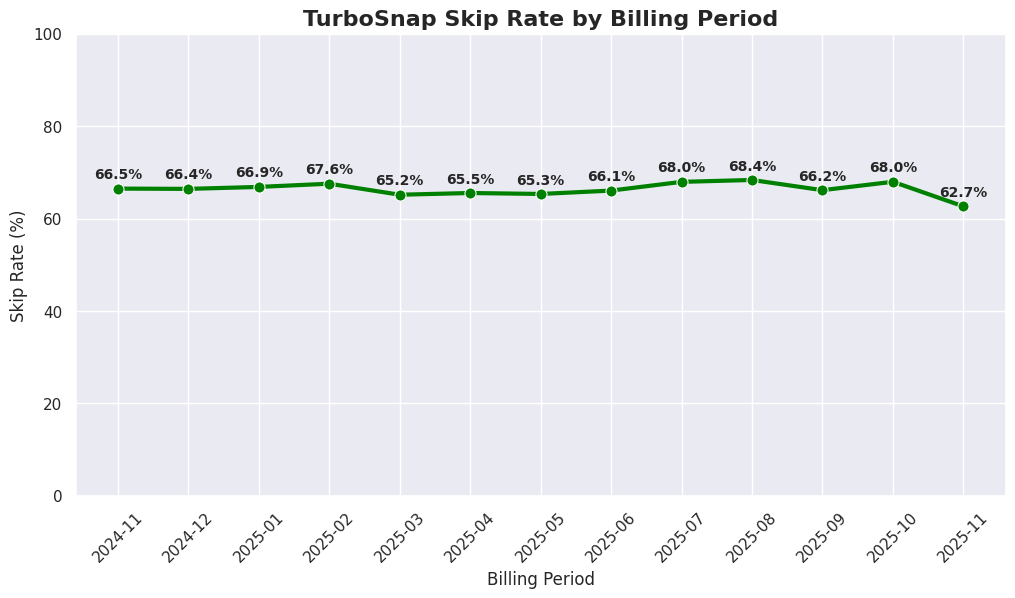

In [61]:
# graph skip rate

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_billing_period, x='Billing Period', y='Skip Rate', marker='o', linewidth=3, markersize=8, 
                color='green')

plt.title('TurboSnap Skip Rate by Billing Period', fontsize=16, fontweight='bold')

plt.xlabel('Billing Period')
plt.xticks(rotation=45)

plt.ylabel('Skip Rate (%)')
plt.ylim(0, 100)

# add value labels on points
for i, (period, rate) in enumerate(zip(df_billing_period.index.astype(str), df_billing_period['Skip Rate'])):
    ax.text(i, rate + 1.5, f'{rate:.1f}%', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

plt.show()

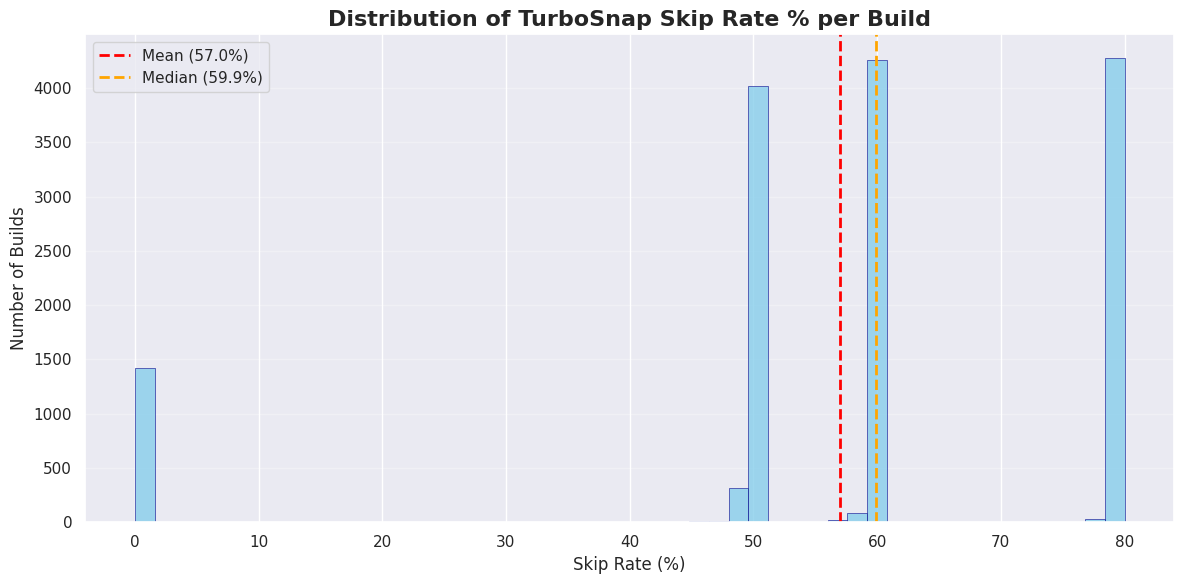

In [62]:
# histogram of skip rate per build

plt.figure(figsize=(12, 6))

# calculate skip rate percentage for each build
# skip builds where there were no snapshots at all (to avoid division by zero)
df_builds_with_snapshots = df[df['Total Potential Snapshots'] > 0].copy()
df_builds_with_snapshots['Skip Rate'] = (
    df_builds_with_snapshots['TurboSnaps'] / 
    df_builds_with_snapshots['Total Potential Snapshots'] * 100
)
skip_rates = df_builds_with_snapshots['Skip Rate']

n_bins = 50
counts, bins, patches = plt.hist(skip_rates, bins=n_bins, color='skyblue', 
                                alpha=0.8, edgecolor='darkblue', linewidth=0.5)
plt.title('Distribution of TurboSnap Skip Rate % per Build', fontsize=16, fontweight='bold')
plt.xlabel('Skip Rate (%)')
plt.ylabel('Number of Builds')
plt.grid(True, alpha=0.3, axis='y')

# vertical lines for mean and median
mean_skip = skip_rates.mean()
median_skip = skip_rates.median()
plt.axvline(x=mean_skip, color='red', linestyle='--', linewidth=2, 
           label=f'Mean ({mean_skip:.1f}%)')
plt.axvline(x=median_skip, color='orange', linestyle='--', linewidth=2, 
           label=f'Median ({median_skip:.1f}%)')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
title("BRANCH USAGE ANALYSIS")

# how many unique branches did we have per billing period?
unique_branches_per_period = df.groupby('Billing Period')['Branch name'].nunique()
print("total unique branches:")
print(unique_branches_per_period.sum())

# how many Chromatic runs did each branch get on average?
runs_per_branch_period = df.groupby(['Billing Period', 'Branch name']).size().reset_index(name='Run Count')
avg_runs_per_branch = runs_per_branch_period.groupby('Billing Period')['Run Count'].mean()

print(f"\naverage runs per branch, by billing period:")
for period in avg_runs_per_branch.index:
    unique_branches = unique_branches_per_period[period]
    avg_runs = avg_runs_per_branch[period]
    total_runs = df[df['Billing Period'] == period].shape[0]
    print(f"{period}: {avg_runs:.1f} avg runs/branch ({unique_branches} unique branches, {total_runs} total runs)")

print(f"\naverage runs per branch overall: {len(df) / df['Branch name'].nunique():.1f}")


BRANCH USAGE ANALYSIS

total unique branches:
1205

average runs per branch, by billing period:
2024-11: 7.5 avg runs/branch (93 unique branches, 700 total runs)
2024-12: 14.5 avg runs/branch (93 unique branches, 1346 total runs)
2025-01: 13.5 avg runs/branch (93 unique branches, 1254 total runs)
2025-02: 12.4 avg runs/branch (93 unique branches, 1150 total runs)
2025-03: 14.1 avg runs/branch (93 unique branches, 1308 total runs)
2025-04: 12.7 avg runs/branch (93 unique branches, 1178 total runs)
2025-05: 13.2 avg runs/branch (93 unique branches, 1229 total runs)
2025-06: 12.3 avg runs/branch (93 unique branches, 1143 total runs)
2025-07: 14.4 avg runs/branch (93 unique branches, 1335 total runs)
2025-08: 11.8 avg runs/branch (93 unique branches, 1099 total runs)
2025-09: 12.1 avg runs/branch (93 unique branches, 1125 total runs)
2025-10: 13.8 avg runs/branch (93 unique branches, 1280 total runs)
2025-11: 3.6 avg runs/branch (89 unique branches, 318 total runs)

average runs per branch

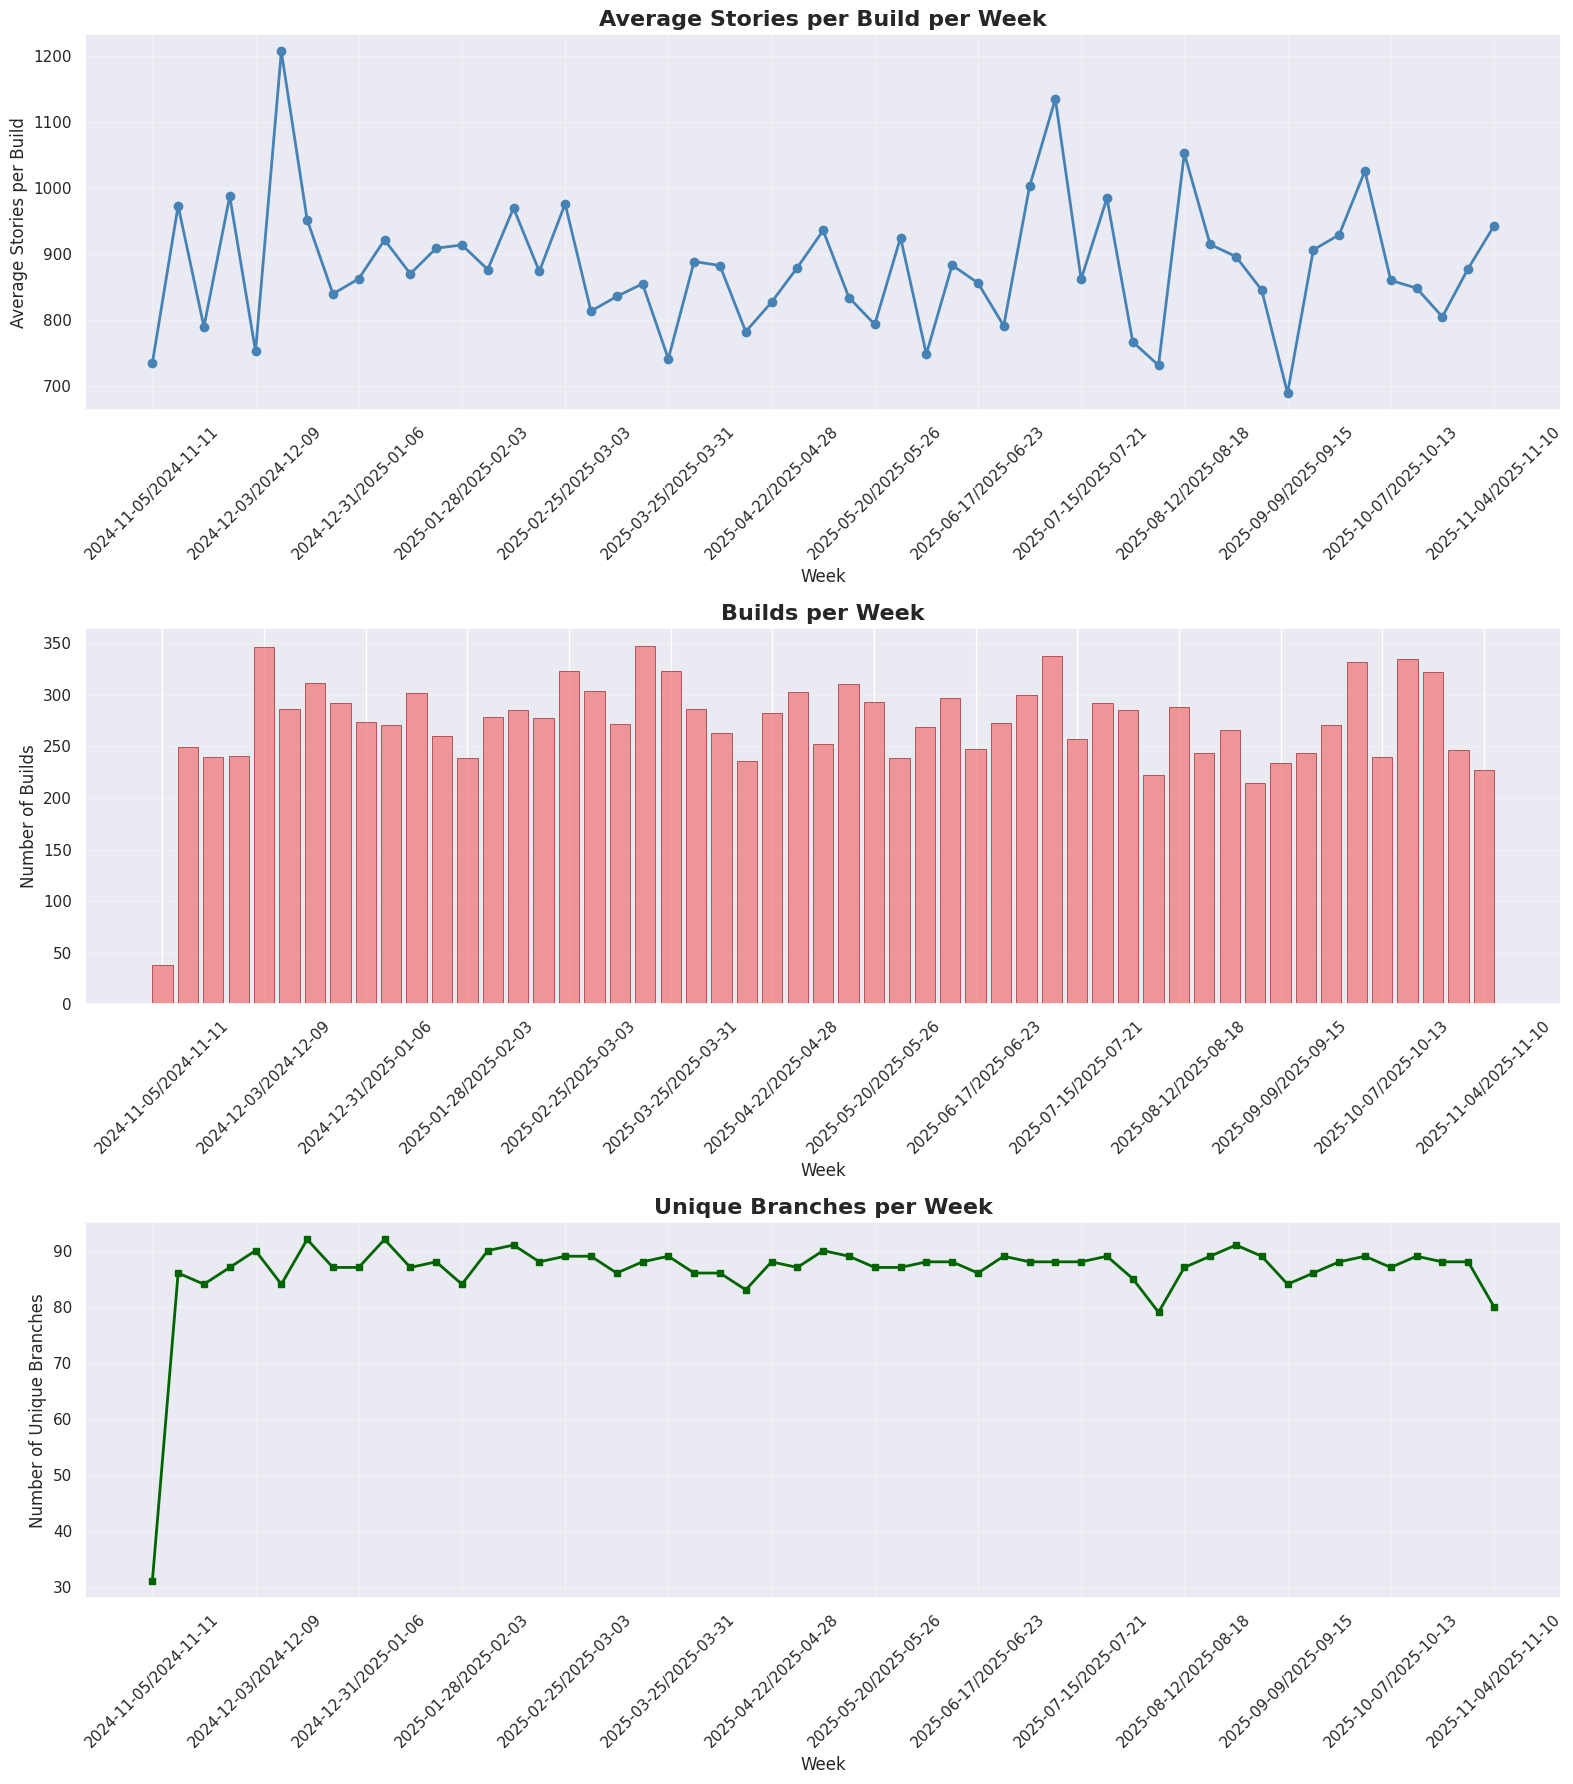

In [ ]:
# visualize weekly usage

df['Week'] = df['Date'].dt.to_period('W-MON').astype(str)

# calculate the three requested metrics per week
weekly_metrics = df.groupby('Week').agg(
    avg_total_stories=('Total Potential Snapshots', 'mean'),
    number_of_builds=('Build ID', 'count'),
    unique_branches=('Branch name', 'nunique')
).round(1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 18))

weeks_range = range(len(weekly_metrics.index))
week_labels = weekly_metrics.index.astype(str)

# graph average stories, per build, per week
ax1.plot(weeks_range, weekly_metrics['avg_total_stories'], 
         marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.set_title('Average Stories per Build per Week', fontsize=16, fontweight='bold')
ax1.set_xlabel('Week')
ax1.set_ylabel('Average Stories per Build')
ax1.grid(True, alpha=0.3)dummy
ax1.set_xticks(weeks_range[::4])  # Show every 4th week to avoid crowding
ax1.set_xticklabels([week_labels[i] for i in range(0, len(week_labels), 4)], rotation=45)

# graph total builds per week
bars2 = ax2.bar(weeks_range, weekly_metrics['number_of_builds'], 
                color='lightcoral', alpha=0.8, edgecolor='darkred', linewidth=0.5)
ax2.set_title('Builds per Week', fontsize=16, fontweight='bold')
ax2.set_xlabel('Week')
ax2.set_ylabel('Number of Builds')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(weeks_range[::4])
ax2.set_xticklabels([week_labels[i] for i in range(0, len(week_labels), 4)], rotation=45)

# graph unique branches per week
ax3.plot(weeks_range, weekly_metrics['unique_branches'], 
         marker='s', linewidth=2, markersize=5, color='darkgreen')
ax3.set_title('Unique Branches per Week', fontsize=16, fontweight='bold')
ax3.set_xlabel('Week')
ax3.set_ylabel('Number of Unique Branches')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(weeks_range[::4])
ax3.set_xticklabels([week_labels[i] for i in range(0, len(week_labels), 4)], rotation=45)

plt.tight_layout()
plt.show()
